In [ ]:
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
!gcc --version
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 707kB/s 
     |████████████████████████████████| 2.2MB 8.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201020-cp36-none-any.whl size=44210 sha256=ff05ca7d98c4d9e6fe5fb62afe3b7d19c74c4cde5bb778f2fd73da969f516d1f
  Stored in directory: /root/.cache/pip/wheels/71/6c/b5/198f89a5c5f127327730248cc623e5a307ad11ed287c3fe391
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
!curl -L https://github.com/SuHsienHuang/Detectron2/blob/main/mask.zip?raw=true > mask.zip 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   126  100   126    0     0    506      0 --:--:-- --:--:-- --:--:--   504
100   137  100   137    0     0    341      0 --:--:-- --:--:-- --:--:--   341
100  944k  100  944k    0     0  1611k      0 --:--:-- --:--:-- --:--:-- 1611k


In [ ]:
!unzip mask.zip > /dev/null

In [ ]:
import detectron2
import numpy as np
import json
import cv2
import random
import os

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

from matplotlib import pyplot as plt

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("mask", {}, "./mask/train/_annotations.coco.json", "./mask/train")
mask_metadata = MetadataCatalog.get("mask")


In [ ]:
mask_metadata

Metadata(evaluator_type='coco', image_root='./mask/train', json_file='./mask/train/_annotations.coco.json', name='mask')

In [ ]:
DatasetCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_minival_100',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2014_minival_100',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'lvis_v1_train',
 'lvis_v1_val',
 'lvis_v1_test_dev',
 'lvis_v1_test_challenge',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'cityscapes_fine_sem_seg_train

In [ ]:
dataset_dicts = DatasetCatalog.get('mask')
print(len(dataset_dicts))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



46


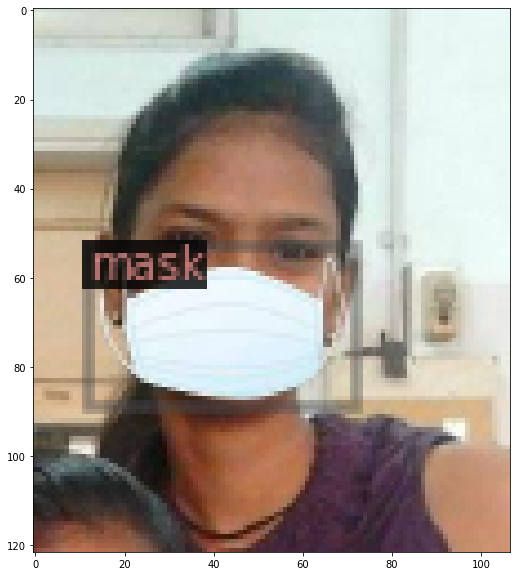

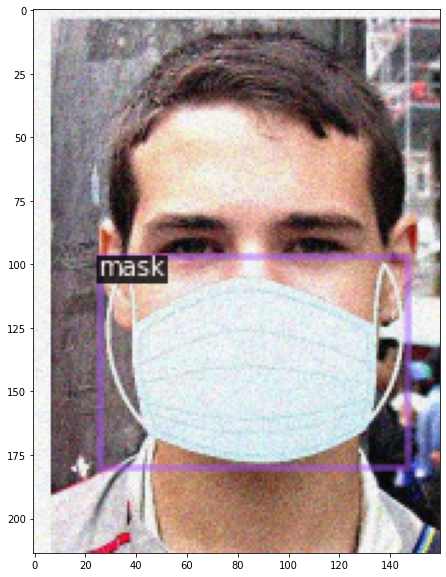

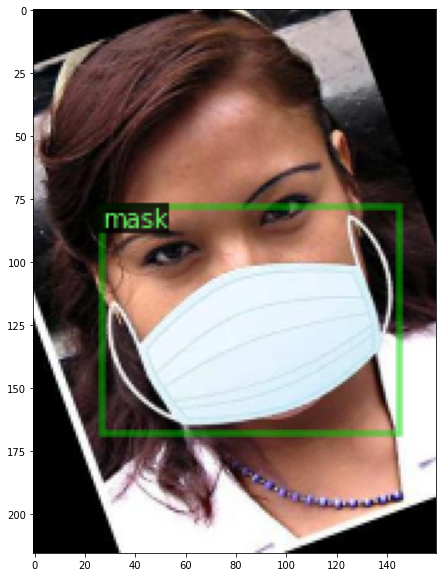

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mask_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,10))
    plt.imshow(vis.get_image())

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mask",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/28 09:00:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[10/28 09:00:25 d2.engine.train_loop]: Starting training from iteration 0
[10/28 09:00:36 d2.utils.events]:  eta: 0:02:33  iter: 19  total_loss: 0.622  loss_cls: 0.602  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.003  loss_rpn_loc: 0.008  time: 0.5546  data_time: 0.0147  lr: 0.000005  max_mem: 2925M
[10/28 09:00:47 d2.utils.events]:  eta: 0:02:23  iter: 39  total_loss: 0.529  loss_cls: 0.505  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.006  loss_rpn_loc: 0.009  time: 0.5481  data_time: 0.0060  lr: 0.000010  max_mem: 2925M
[10/28 09:00:58 d2.utils.events]:  eta: 0:02:13  iter: 59  total_loss: 0.393  loss_cls: 0.372  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.004  loss_rpn_loc: 0.007  time: 0.5498  data_time: 0.0063  lr: 0.000015  max_mem: 2925M
[10/28 09:01:09 d2.utils.events]:  eta: 0:02:03  iter: 79  total_loss: 0.262  loss_cls: 0.248  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.006  loss_rpn_loc: 0.010  time: 0.5516  data_time: 0.0058  lr:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
val_dicts = DatasetCatalog.get('mask')


WARNING [10/28 09:03:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/28 09:03:52 d2.data.datasets.coco]: Loaded 46 images in COCO format from ./mask/train/_annotations.coco.json


In [ ]:
for d in random.sample(val_dicts, 3): 
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  print(outputs["instances"].pred_classes)
  print(outputs["instances"].pred_boxes)

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))
tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))
tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


WARNING [10/28 09:03:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/28 09:03:57 d2.data.datasets.coco]: Loaded 46 images in COCO format from ./mask/train/_annotations.coco.json


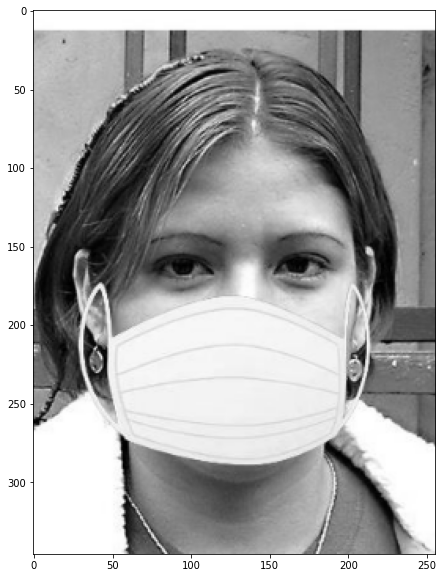

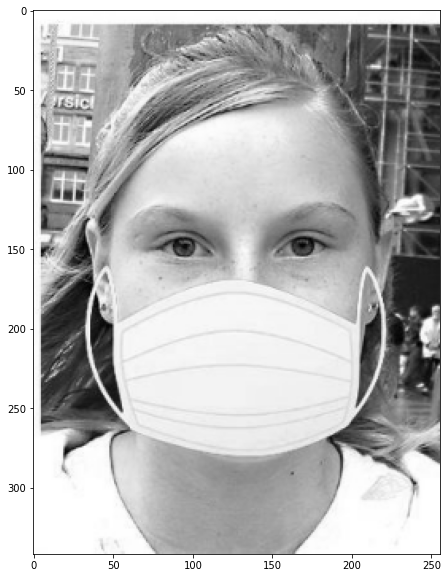

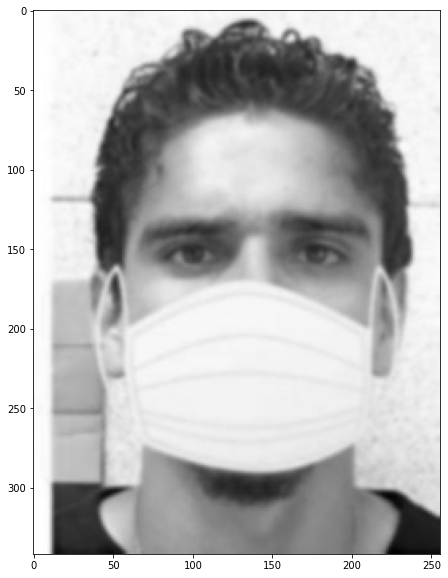

In [ ]:
val_dicts = DatasetCatalog.get('mask')
for d in random.sample(val_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,10))
    plt.imshow(v.get_image()[:,:,::-1])
    